In [1]:
import pandas as pd

# Load the dataset
file_path = 'crypto_cleaned_data.csv'
crypto_data = pd.read_csv(file_path)

# Reshape the dataset
columns_to_melt = [col for col in crypto_data.columns if col != 'Date']

# Melting the dataset to long format
crypto_long = crypto_data.melt(
    id_vars=['Date'],
    value_vars=columns_to_melt,
    var_name='Symbol_Attribute',
    value_name='Value'
)

# Splitting 'Symbol_Attribute' into 'Symbol' and 'Attribute'
crypto_long[['Symbol', 'Attribute']] = crypto_long['Symbol_Attribute'].str.extract(r'([^_]+)_([^_]+)')

# Pivoting back to wide format with separate columns for attributes
crypto_wide = crypto_long.pivot_table(
    index=['Date', 'Symbol'], 
    columns='Attribute', 
    values='Value'
).reset_index()




crypto_wide.to_csv('reshaped_crypto_data_wide.csv', index=False)
print("Reshaped dataset saved as 'reshaped_crypto_data_wide.csv'")

Reshaped dataset saved as 'reshaped_crypto_data_wide.csv'


Cluster into groups 

In [4]:
import pandas as pd

# Load the dataset
file_path = 'crypto_complete_data_1_year.csv'
crypto_data = pd.read_csv(file_path)

# Extract date column and cryptocurrency names with "Adj_Close"
date_column = "Date"
crypto_columns = [col for col in crypto_data.columns if "Adj_Close" in col]

# Keep only the Date and relevant "Adj_Close" columns
reshaped_data = crypto_data[[date_column] + crypto_columns]

# Convert Date to a standard datetime format
reshaped_data[date_column] = pd.to_datetime(reshaped_data[date_column])

# Melt the data to have 'Cryptocurrency' as a variable and 'Adj_Close' as values
melted_data = reshaped_data.melt(id_vars=[date_column], 
                                 var_name="Cryptocurrency", 
                                 value_name="Adj_Close")

# Extract cryptocurrency from column names
melted_data['Cryptocurrency'] = melted_data['Cryptocurrency'].str.split('-').str[0]

# Pivot the data to make rows as cryptocurrencies and columns as dates
pivoted_data = melted_data.pivot(index="Cryptocurrency", 
                                 columns=date_column, 
                                 values="Adj_Close")

# Sort columns by date for clarity
pivoted_data = pivoted_data.sort_index(axis=1)

# Reformat the column dates to 'DD-MM-YYYY' format
pivoted_data.columns = pivoted_data.columns.to_series().apply(lambda x: pd.to_datetime(x).strftime('%d-%m-%Y'))

# Save the transformed DataFrame to a CSV file
pivoted_data.to_csv('transformed_cryptocurrency_data.csv')


print(pivoted_data.head())

Date            26-12-2023  27-12-2023  28-12-2023  29-12-2023  30-12-2023  \
Cryptocurrency                                                               
ADA               0.608799    0.633535    0.617422    0.608494    0.601964   
ALGO              0.234494    0.229226    0.234213    0.226423    0.221767   
APT               0.003642    0.001969    0.002115    0.004423    0.002284   
ARB               0.000425    0.000434    0.000426    0.000421    0.000422   
ATOM             11.616012   11.965517   11.429394   10.991527   10.766783   

Date            31-12-2023  01-01-2024  02-01-2024  03-01-2024  04-01-2024  \
Cryptocurrency                                                               
ADA               0.594205    0.623110    0.605667    0.557286    0.570567   
ALGO              0.222777    0.238981    0.226959    0.204728    0.207866   
APT               0.002418    0.002295    0.004057    0.002494    0.002184   
ARB               0.000423    0.000442    0.000460    0.000428 

/var/folders/_s/s7gr01nn3jn52_zd_my2hsdr0000gn/T/ipykernel_52176/4204165312.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reshaped_data[date_column] = pd.to_datetime(reshaped_data[date_column])


Silhouette Score for 4 clusters: 0.8273719007681738

Selected cryptocurrency from each cluster:
Cluster 0: TRX
Cluster 1: BTC
Cluster 2: ETH
Cluster 3: BCH


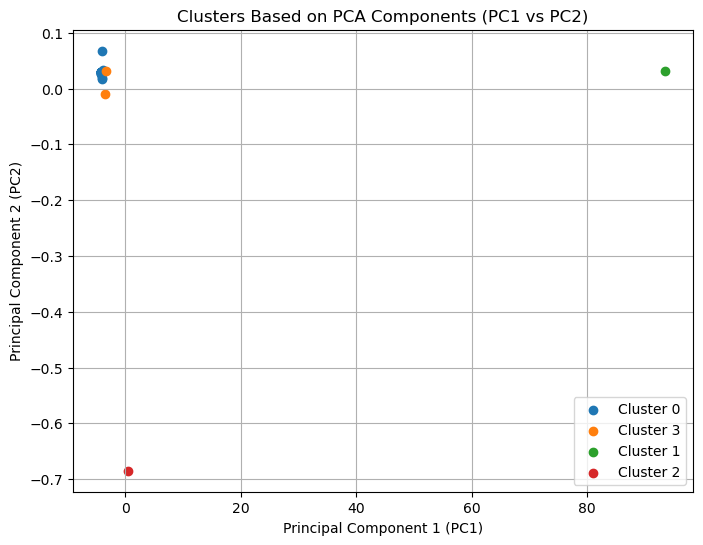

In [6]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load your dataset
file_path = 'transformed_cryptocurrency_data.csv'  
pivoted_data = pd.read_csv(file_path, index_col=0)

#  Handle Missing Values with Linear Interpolation
pivoted_data = pivoted_data.interpolate(method='linear')

#  Standardize the data for PCA
scaler = StandardScaler()
pivoted_data_scaled = scaler.fit_transform(pivoted_data)

#  Apply PCA to reduce dimensionality to 10 components
pca = PCA(n_components=10)
pca_result = pca.fit_transform(pivoted_data_scaled)

# Create a DataFrame for PCA results
pca_columns = [f'PC{i+1}' for i in range(10)]
pca_df = pd.DataFrame(pca_result, columns=pca_columns, index=pivoted_data.index)

#  Perform clustering on PCA-reduced data
n_clusters = 4  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pca_df['Cluster'] = kmeans.fit_predict(pca_result)

#  Compute the Silhouette Score
silhouette_avg = silhouette_score(pca_result, pca_df['Cluster'])
print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")

# Save the PCA and clustering results
pca_df.to_csv('pca_10_components_and_clustering_results.csv')

#  Select one cryptocurrency from each cluster and print it
print("\nSelected cryptocurrency from each cluster:")
for cluster, group in pca_df.groupby('Cluster'):
    selected_crypto = group.sample(1) 
    print(f"Cluster {cluster}: {selected_crypto.index[0]}")

# Visualize the first two PCA components and clusters
plt.figure(figsize=(8, 6))
for cluster in pca_df['Cluster'].unique():
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')
    
plt.title('Clusters Based on PCA Components (PC1 vs PC2)')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend()
plt.grid()
plt.show()